In [86]:
import rosbag
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt


def list_topics(bag_file):
    with rosbag.Bag(bag_file, 'r') as bag:
        topics = bag.get_type_and_topic_info()[1].keys()
        return topics
    
def save_topics_to_file(topics, output_file):
    with open(output_file, 'w') as f:
        for topic in topics:
            f.write(topic + '\n')

In [509]:
import pandas as pd

# Values of the time for all the experiments
# differential
diff_exp_1_go = [11.06, 95.89]
diff_exp_1_back = [129.65, 257.98]

diff_exp_2_go = [12.11, 96.97]
diff_exp_2_back = [130.81, 238.91]

diff_exp_3_go = [10.06, 110.98]
diff_exp_3_back = [137.20, 253.99]

diff_exp_4_go = [10.10, 100.91]
diff_exp_4_back = [145.83, 266.74]

diff_exp_5_go = [10.08, 101.45]
diff_exp_5_back = [129.66, 260.13]

# Omnidifferential
omni_exp_1_go = [13.10, 77.70]
omni_exp_1_back = [103.40, 173.63]

omni_exp_2_go = [11.61, 73.26]
omni_exp_2_back = [109.60, 180.86]

omni_exp_3_go = [11.10, 86.32]
omni_exp_3_back = [130.18, 212.62]

omni_exp_4_go = [14.13, 91.38]
omni_exp_4_back = [146.93, 253.76]

omni_exp_5_go = [13.58, 81.28]
omni_exp_5_back = [109.05, 207.15]

# Create a DataFrame with the specified columns and rows
data = {
    "diff_go": [[diff_exp_1_go[0], diff_exp_1_go[1]], [diff_exp_2_go[0], diff_exp_2_go[1]] , [diff_exp_3_go[0], diff_exp_3_go[1]], [diff_exp_4_go[0], diff_exp_4_go[1]], [diff_exp_5_go[0], diff_exp_5_go[1]]],
    "diff_back": [[diff_exp_1_back[0], diff_exp_1_back[1]], [diff_exp_2_back[0], diff_exp_2_back[1]], [diff_exp_3_back[0], diff_exp_3_back[1]], [diff_exp_4_back[0], diff_exp_4_back[1]], [diff_exp_5_back[0], diff_exp_5_back[1]]],
    "omni_go": [[omni_exp_1_go[0], omni_exp_1_go[1]], [omni_exp_2_go[0], omni_exp_2_go[1]], [omni_exp_3_go[0], omni_exp_3_go[1]], [omni_exp_4_go[0], omni_exp_4_go[1]], [omni_exp_5_go[0], omni_exp_5_go[1]]],
    "omni_back": [[omni_exp_1_back[0], omni_exp_1_back[1]], [omni_exp_2_back[0], omni_exp_2_back[1]], [omni_exp_3_back[0], omni_exp_3_back[1]], [omni_exp_4_back[0], omni_exp_4_back[1]], [omni_exp_5_back[0], omni_exp_5_back[1]]]
}

df = pd.DataFrame(data)
print(df)

# Save the DataFrame to a CSV file
df.to_csv("time_values.csv")
# Read the CSV file into a DataFrame

           diff_go         diff_back         omni_go         omni_back
0   [11.06, 95.89]  [129.65, 257.98]    [13.1, 77.7]   [103.4, 173.63]
1   [12.11, 96.97]  [130.81, 238.91]  [11.61, 73.26]   [109.6, 180.86]
2  [10.06, 110.98]   [137.2, 253.99]   [11.1, 86.32]  [130.18, 212.62]
3   [10.1, 100.91]  [145.83, 266.74]  [14.13, 91.38]  [146.93, 253.76]
4  [10.08, 101.45]  [129.66, 260.13]  [13.58, 81.28]  [109.05, 207.15]


In [451]:
import os

experiment = 4

# bag_dir = '../../../dissertation_data/diff_2'
bag_dir = '../../../dissertation_data/omni'

# List all .bag files in the directory
bag_files = sorted([f for f in os.listdir(bag_dir) if f.endswith('.bag')])

print(f"Found {len(bag_files)} .bag files in the directory: {bag_files}")

bag_file = bag_dir + '/' + bag_files[experiment]

output_file = 'topics_list.txt'
topics = list_topics(bag_file)
save_topics_to_file(topics, output_file)
print(f"Available topics have been saved to {output_file}")

Found 5 .bag files in the directory: ['a_first_perfect.bag', 'b_second_perfect.bag', 'c_third_perfect.bag', 'd_forth_perfect.bag', 'e_fifth_little_scratch_end.bag']
Available topics have been saved to topics_list.txt


In [452]:
bag = rosbag.Bag(bag_file, 'r')
poses = []
times = []

# poses_P1 = []
# times_P1 = []

# '/vrpn_client_node/P1/pose'

# Extract PoseStamped messages
for topic, msg, t in bag.read_messages(topics=['/vrpn_client_node/L1/pose']):
    
    if topic == '/vrpn_client_node/L1/pose':
        poses.append(msg)
        times.append(t)
    
    # if topic == '/vrpn_client_node/P1/pose':
    #     poses_P1.append(msg)
    #     times_P1.append(t)

bag.close()


In [453]:
def calculate_velocity_with_accumulation(poses, times, min_time_interval=0.1):
    velocities = []
    velocity_times = []  # Track the times associated with the velocities
    start_time = times[0].to_sec()
    start_pose = poses[0].pose.position

    for i in range(1, len(poses)):
        current_time = times[i].to_sec()
        current_pose = poses[i].pose.position
        
        # Accumulate time and position differences until min_time_interval has passed
        if current_time - start_time >= min_time_interval:
            # Calculate position differences (distance traveled)
            dx = current_pose.x - start_pose.x
            dy = current_pose.y - start_pose.y
            dz = current_pose.z - start_pose.z
            
            # Calculate the total time difference
            dt = current_time - start_time

            # Linear velocity magnitude
            velocity = np.sqrt(dx**2 + dy**2 + dz**2) / dt
            velocities.append(velocity)
            velocity_times.append(current_time)

            # Reset the start time and pose
            start_time = current_time
            start_pose = current_pose

    return velocities, velocity_times

def butterworth_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Velocity L1

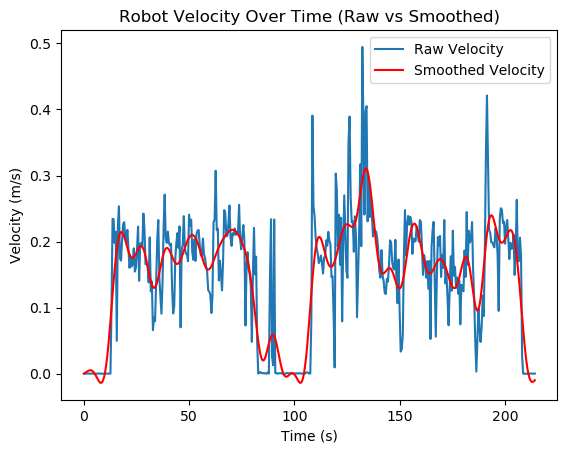

In [454]:
min_time_interval = 0.5
velocities, velocity_times = calculate_velocity_with_accumulation(poses, times, min_time_interval)

# Calculate the new sampling rate based on accumulated time
total_duration = velocity_times[-1] - velocity_times[0]
new_sampling_rate = len(velocities) / total_duration 

cutoff_frequency = 0.1
smoothed_velocities = butterworth_filter(velocities, cutoff_frequency, new_sampling_rate)

# Subtract the first timestamp to make time relative to t129.65he start
velocity_times_relative = [t - velocity_times[0] for t in velocity_times]

# Plot with relative time (in seconds)
plt.figure()
plt.plot(velocity_times_relative, velocities, label='Raw Velocity')
plt.plot(velocity_times_relative, smoothed_velocities, label='Smoothed Velocity', color='red')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Robot Velocity Over Time (Raw vs Smoothed)')
plt.legend()
plt.show()


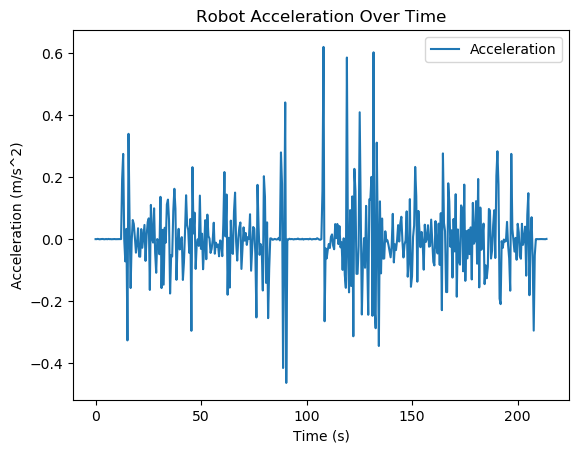

In [455]:
def calculate_acceleration(velocities, velocity_times):
    accelerations = []
    acceleration_times = []

    for i in range(1, len(velocities)):
        dv = velocities[i] - velocities[i - 1]
        dt = velocity_times[i] - velocity_times[i - 1]
        acceleration = dv / dt
        accelerations.append(acceleration)
        acceleration_times.append(velocity_times[i])

    return accelerations, acceleration_times

accelerations, acceleration_times = calculate_acceleration(velocities, velocity_times)

# Subtract the first timestamp to make time relative to the start
acceleration_times_relative = [t - acceleration_times[0] for t in acceleration_times]

# Plot acceleration with relative time (in seconds)
plt.figure()
plt.plot(acceleration_times_relative, accelerations, label='Acceleration')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.title('Robot Acceleration Over Time')
plt.legend()
plt.show()

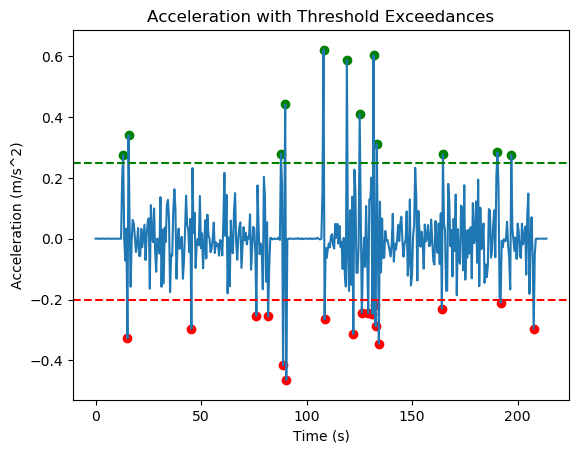

In [463]:
upper_threshold = 0.25
lower_threshold = -0.2

accelerations_array = np.array(accelerations)
positions_lower = np.where(accelerations_array <= lower_threshold)[0]
positions_upper = np.where(accelerations_array >= upper_threshold)[0]

plt.figure()
plt.plot(acceleration_times_relative, accelerations, label='Acceleration')
plt.scatter(np.array(acceleration_times_relative)[positions_lower], np.array(accelerations)[positions_lower], color='red', label='Lower Threshold Exceeded')
plt.scatter(np.array(acceleration_times_relative)[positions_upper], np.array(accelerations)[positions_upper], color='green', label='Upper Threshold Exceeded')
plt.axhline(y=lower_threshold, color='red', linestyle='--', label='Lower Threshold')
plt.axhline(y=upper_threshold, color='green', linestyle='--', label='Upper Threshold')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.title('Acceleration with Threshold Exceedances')
# plt.ylim(-0.5, 0.5)
# plt.legend()
plt.show()

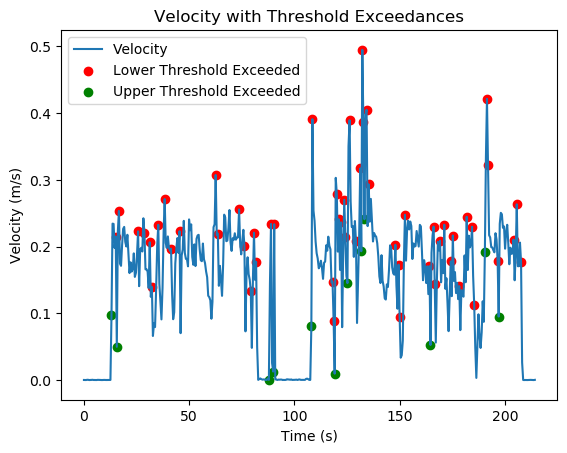

In [457]:
plt.figure()
plt.plot(velocity_times_relative, velocities, label='Velocity')
plt.scatter(np.array(velocity_times_relative)[positions_lower], np.array(velocities)[positions_lower], color='red', label='Lower Threshold Exceeded')
plt.scatter(np.array(velocity_times_relative)[positions_upper], np.array(velocities)[positions_upper], color='green', label='Upper Threshold Exceeded')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity with Threshold Exceedances')
plt.legend()
plt.show()

Length of part 1: 135
Length of part 2: 195


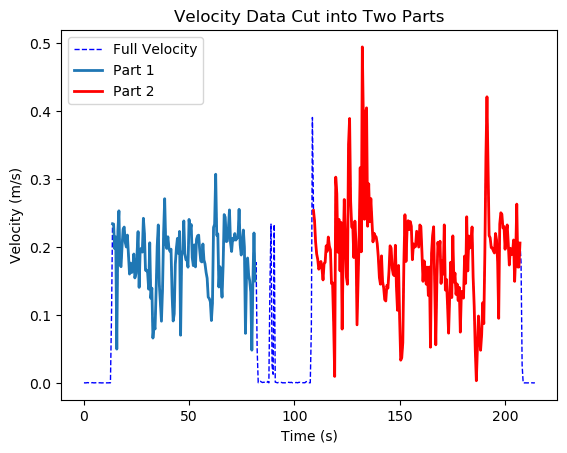

In [479]:
first_upper = 0
first_lower = 3

first_upper_sum = 1
first_lower_sum = 0

second_upper = 4
second_lower = -1

second_upper_sum = 2
second_lower_sum = 0

# Cut the data into two parts
part1_velocities = velocities[positions_upper[first_upper]+first_upper_sum:positions_lower[first_lower]+first_lower_sum]
part2_velocities = velocities[positions_upper[second_upper]+second_upper_sum:positions_lower[second_lower]+second_lower_sum]

part1_times = velocity_times_relative[positions_upper[first_upper]+first_upper_sum:positions_lower[first_lower]+first_lower_sum]
part2_times = velocity_times_relative[positions_upper[second_upper]+second_upper_sum:positions_lower[second_lower]+second_lower_sum]

# Print the lengths of the parts to verify
print(f"Length of part 1: {len(part1_velocities)}")
print(f"Length of part 2: {len(part2_velocities)}")

# Plot the two parts
plt.figure()
plt.plot(velocity_times_relative, velocities, label='Full Velocity', color='blue', linestyle='--', linewidth=1)
plt.plot(part1_times, part1_velocities, label='Part 1', linewidth=2)
plt.plot(part2_times, part2_velocities, label='Part 2', color='red', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity Data Cut into Two Parts')
plt.legend()
plt.show()

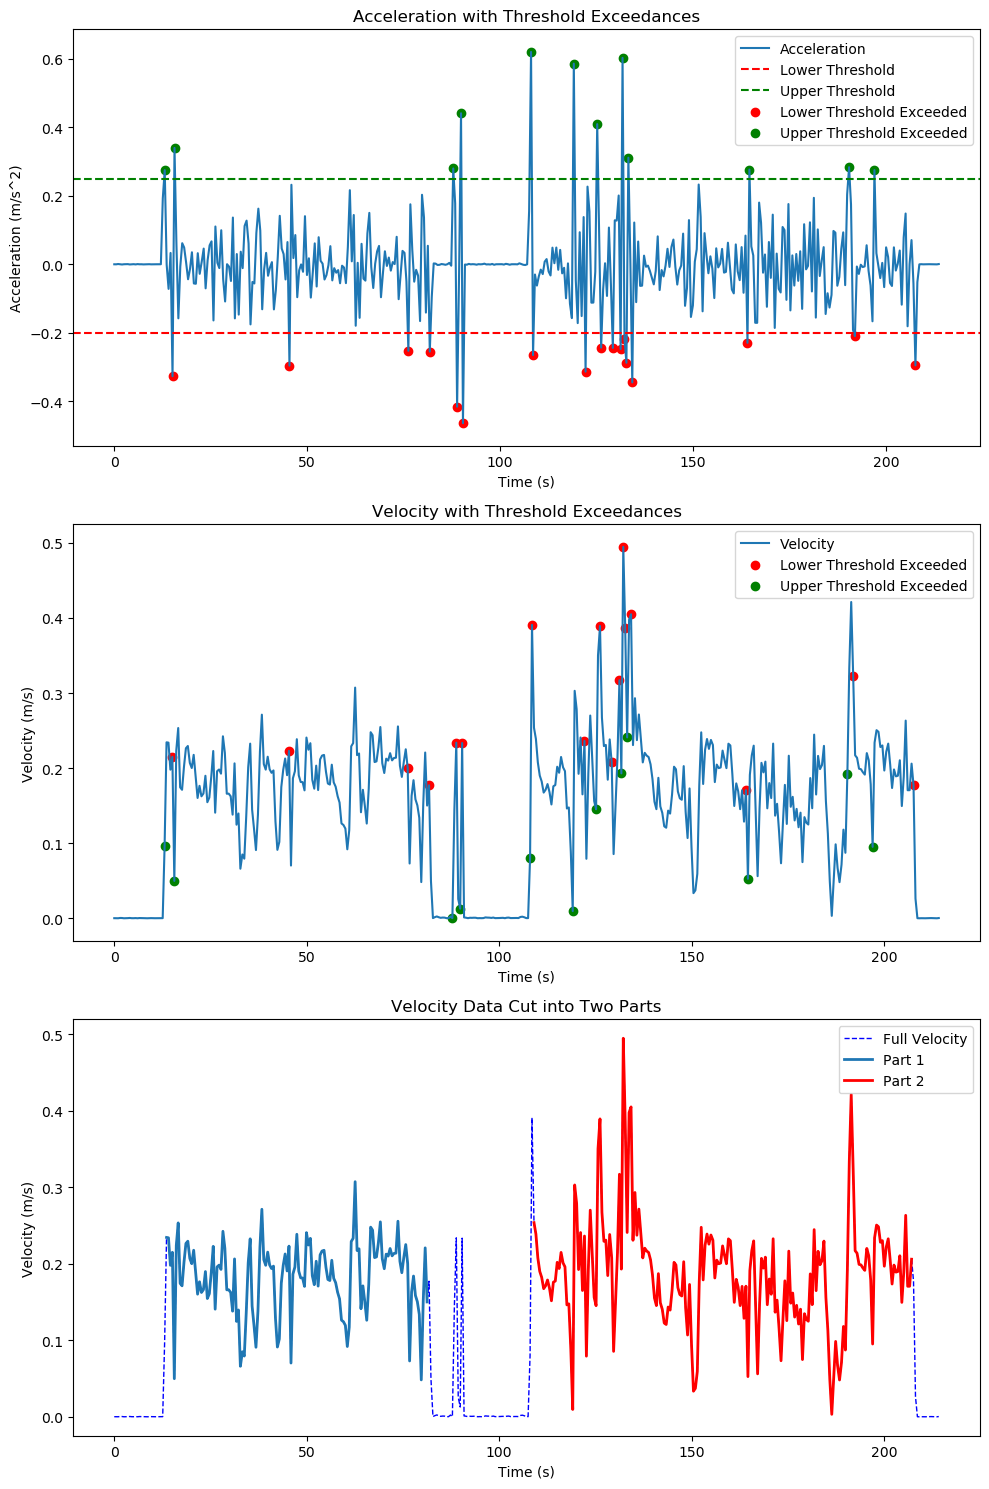

In [480]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot 'Acceleration with Threshold Exceedances'
axs[0].plot(acceleration_times_relative, accelerations, label='Acceleration')
axs[0].scatter(np.array(acceleration_times_relative)[positions_lower], np.array(accelerations)[positions_lower], color='red', label='Lower Threshold Exceeded')
axs[0].scatter(np.array(acceleration_times_relative)[positions_upper], np.array(accelerations)[positions_upper], color='green', label='Upper Threshold Exceeded')
axs[0].axhline(y=lower_threshold, color='red', linestyle='--', label='Lower Threshold')
axs[0].axhline(y=upper_threshold, color='green', linestyle='--', label='Upper Threshold')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Acceleration (m/s^2)')
axs[0].set_title('Acceleration with Threshold Exceedances')
axs[0].legend()

# Plot 'Velocity with Threshold Exceedances'
axs[1].plot(velocity_times_relative, velocities, label='Velocity')
axs[1].scatter(np.array(velocity_times_relative)[positions_lower], np.array(velocities)[positions_lower], color='red', label='Lower Threshold Exceeded')
axs[1].scatter(np.array(velocity_times_relative)[positions_upper], np.array(velocities)[positions_upper], color='green', label='Upper Threshold Exceeded')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Velocity (m/s)')
axs[1].set_title('Velocity with Threshold Exceedances')
axs[1].legend()

# Plot 'Velocity Data Cut into Two Parts'
axs[2].plot(velocity_times_relative, velocities, label='Full Velocity', color='blue', linestyle='--', linewidth=1)
axs[2].plot(part1_times, part1_velocities, label='Part 1', linewidth=2)
axs[2].plot(part2_times, part2_velocities, label='Part 2', color='red', linewidth=2)
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Velocity (m/s)')
axs[2].set_title('Velocity Data Cut into Two Parts')
axs[2].legend()

plt.tight_layout()
plt.show()

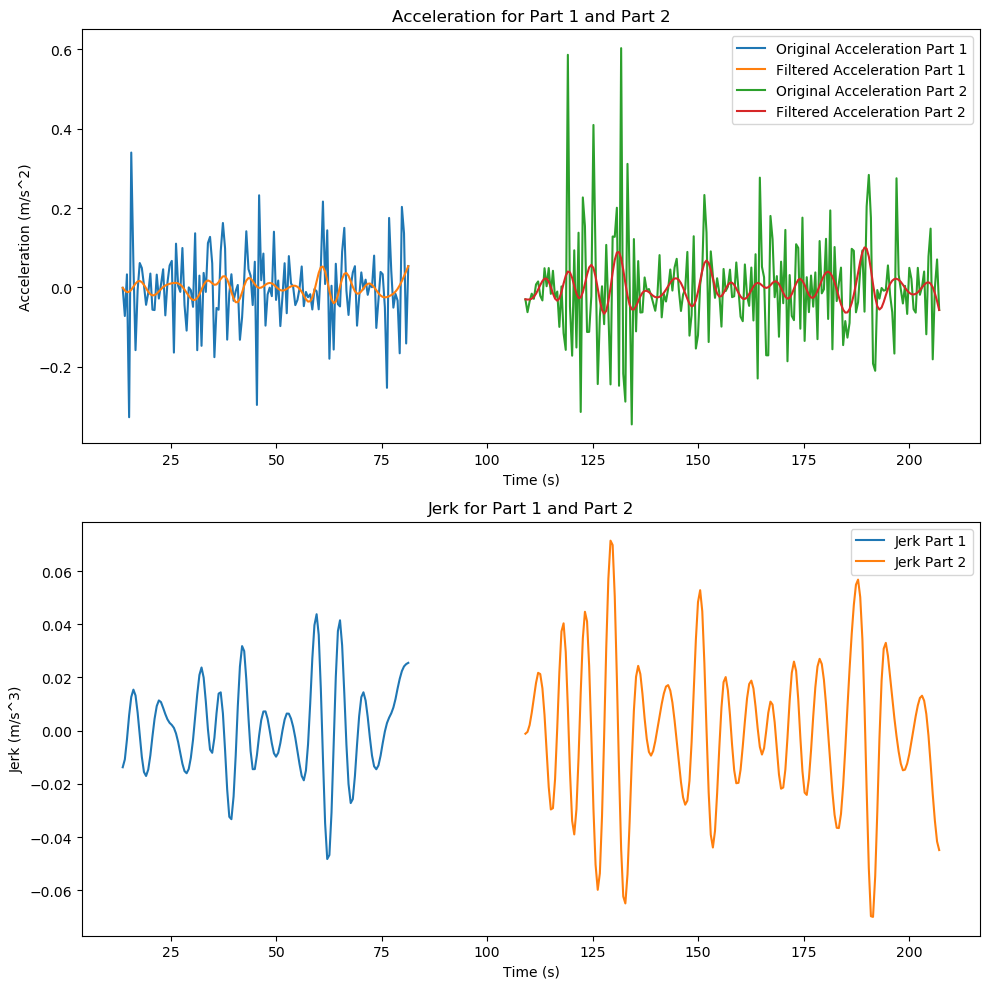

In [481]:
Filter = True

first_acceleration = accelerations_array[positions_upper[first_upper]+first_upper_sum:positions_lower[first_lower]+first_lower_sum]
duration_first_acceleration = acceleration_times_relative[positions_lower[first_lower]+first_lower_sum] - acceleration_times_relative[positions_upper[first_upper]+first_upper_sum]

second_acceleration = accelerations_array[positions_upper[second_upper]+second_upper_sum:positions_lower[second_lower]+second_lower_sum]
duration_second_acceleration = acceleration_times_relative[positions_lower[second_lower]+second_lower_sum] - acceleration_times_relative[positions_upper[second_upper]+second_upper_sum]

first_sampling_rate = len(first_acceleration) / duration_first_acceleration 
second_sampling_rate = len(second_acceleration) / duration_second_acceleration

first_cutoff_frequency = 0.2
second_cutoff_frequency = 0.2

# Filter the acceleration data for part 1
filtered_acceleration_part1 = butterworth_filter(
    first_acceleration,
    first_cutoff_frequency,
    first_sampling_rate
)

# Filter the acceleration data for part 2
filtered_acceleration_part2 = butterworth_filter(
    second_acceleration,
    second_cutoff_frequency,
    second_sampling_rate
)

if not Filter:
    filtered_acceleration_part1 = first_acceleration
    filtered_acceleration_part2 = second_acceleration

# Calculate the acceleration derivative (jerk) for part 1
jerk_part1 = np.gradient(filtered_acceleration_part1, part1_times)

# Calculate the acceleration derivative (jerk) for part 2
jerk_part2 = np.gradient(filtered_acceleration_part2, part2_times)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot the acceleration and filtered acceleration for part 1 and part 2 on the same subplot
axs[0].plot(part1_times, accelerations_array[positions_upper[first_upper]+first_upper_sum:positions_lower[first_lower]+first_lower_sum], label='Original Acceleration Part 1')
axs[0].plot(part1_times, filtered_acceleration_part1, label='Filtered Acceleration Part 1')
axs[0].plot(part2_times, accelerations_array[positions_upper[second_upper]+second_upper_sum:positions_lower[second_lower]+second_lower_sum], label='Original Acceleration Part 2')
axs[0].plot(part2_times, filtered_acceleration_part2, label='Filtered Acceleration Part 2')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Acceleration (m/s^2)')
axs[0].set_title('Acceleration for Part 1 and Part 2')
axs[0].legend()

# Plot the acceleration derivative (jerk) for part 1 and part 2 on the same subplot
axs[1].plot(part1_times, jerk_part1, label='Jerk Part 1')
axs[1].plot(part2_times, jerk_part2, label='Jerk Part 2')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Jerk (m/s^3)')
axs[1].set_title('Jerk for Part 1 and Part 2')
axs[1].legend()

plt.tight_layout()
plt.show()


# Velocity P1

In [482]:
# min_time_interval = 1
# velocities, velocity_times = calculate_velocity_with_accumulation(poses_P1, times_P1, min_time_interval)

# # Calculate the new sampling rate based on accumulated time
# total_duration = velocity_times[-1] - velocity_times[0]
# new_sampling_rate = len(velocities) / total_duration 

# cutoff_frequency = 0.1
# smoothed_velocities = butterworth_filter(velocities, cutoff_frequency, new_sampling_rate)

# # Subtract the first timestamp to make time relative to the start
# velocity_times_relative = [t - velocity_times[0] for t in velocity_times]

# # Plot with relative time (in seconds)
# plt.figure()
# plt.plot(velocity_times_relative, velocities, label='Raw Velocity')
# plt.plot(velocity_times_relative, smoothed_velocities, label='Smoothed Velocity', color='red')
# plt.xlabel('Time (s)')
# plt.ylabel('Velocity (m/s)')
# plt.title('Robot Velocity Over Time (Raw vs Smoothed)')
# plt.legend()
# plt.show()


In [483]:
# from PIL import Image
# import pytesseract

# # Função para converter imagem em texto e ajustar quebras de linha
# def imagem_para_texto(caminho_imagem, idioma='eng'):
#     """
#     Converte imagem para texto usando Tesseract OCR e ajusta quebras de linha.
    
#     :param caminho_imagem: Caminho da imagem a ser processada.
#     :param idioma: Idioma a ser usado pelo Tesseract (por exemplo, 'por' para português).
#     :return: Texto extraído da imagem, com quebras de linha ajustadas.
#     """
#     # Abrir a imagem
#     imagem = Image.open(caminho_imagem)
    
#     # Extrair texto da imagem
#     texto = pytesseract.image_to_string(imagem, lang=idioma)
    
#     # Ajustar as quebras de linha (remover quebras de linha desnecessárias)
#     texto_ajustado = texto.replace('\n', ' ').strip()
    
#     return texto_ajustado

# # Caminho da imagem
# caminho_imagem = '24-27/24-27-4.png' 

# # Extrair texto da imagem (usando português como idioma)
# texto_extraido = imagem_para_texto(caminho_imagem, idioma='por')

# # Exibir o texto extraído com quebras de linha ajustadas
# print(texto_extraido)

# # Opcional: Salvar o texto extraído em um arquivo .txt
# with open('texto_extraido.txt', 'w') as arquivo_texto:
#     arquivo_texto.write(texto_extraido)